This notebook shows how ensemble-based uncertainty computation could be used on real data. More specifically, the further analysis provided for the MC-Dropout virtual ensemble trained on a RICH dataset. This notebook contains only code snippets and results based on the already trained model.

**NOTE!** The code uses processed data from the LHCb experiment. Collaboration members please write nikita.kazeev@cern.ch for access.

In [ ]:
# codebase
!git clone https://gitlab.com/lambda-hse/lhcb-rich-gan-uncertainty

# model checkpoint downloading and extraction
!wget https://www.dropbox.com/s/dl/yqv35l4bc4rtfqm/btstrap_line_test_ckpts.zip && unzip -qq btstrap_line_test_ckpts.zip

In [ ]:
# third-party libraries installation
!pip install tensorflow-addons

In [3]:
import sys
sys.path.append('lhcb-rich-gan-uncertainty')

In [4]:
import datetime
import os
import glob
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from experiments.efficiency.uncertainty_model_train import train_model
from experiments.efficiency.uncertainty_models import uncertainty_mlp
from experiments.efficiency.uncertainty_utils import (
    efficiency_bands_with_uncertainty, efficiency_momentum_with_uncertainty)
from experiments.efficiency.utils import (
    efficiency_bands, efficiency_momentum, ensemble_and_ref_model_inference,
    ensemble_and_ref_model_inference_on_bands, tf_to_numpy_dataset,
    threshold_selection)

from src.cramer_gan_trainer import CramerGANTrainer
from src.datasets.utils_rich import (get_merged_typed_dataset,
                                     parse_dataset_np, parse_example)
from src.models.gans.discriminators.fcn_disc import RICHDiscriminator
from src.models.gans.generators.fcn_gen import RichMCDropV2Subcl

/usr/local/lib/python3.7/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.4.0 and strictly below 2.7.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.7.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [5]:
# TensorFlow warnings hiding
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

### Data preparation

The RICH dataset contains sets of data for different types of particles. Each datapoint in RICH consists of $\mathbb{X}, \mathbb{Y}$ and weight $w$, where the input data $\mathbb{X} \in \mathbb{R}^3$, where features of input data consist of pseudorapidity (ETA), momentum (P), number of tracks; the output is data $\mathbb{Y} \in \mathbb{R}^5$, where each feature is the difference of log-likelihood values between particle hypothesis and pion hypothesis. The particles are kaon, proton, muon, electron, and values below the threshold. Without loss of generality, the data for **pion** particle was chosen. Pion data will be used for further analysis.

In [6]:
particle_type = 'pion'
data_dir = 'rich'

In [7]:
ls rich

kaon2_-_down_2016_.csv  muon_-_down_2016_.csv   pion_-_down_2016_.csv
kaon2_+_down_2016_.csv  muon_+_down_2016_.csv   pion_+_down_2016_.csv
kaon2_-_up_2016_.csv    muon_-_up_2016_.csv     pion_-_up_2016_.csv
kaon2_+_up_2016_.csv    muon_+_up_2016_.csv     pion_+_up_2016_.csv
kaon_-_down_2016_.csv   pion2_-_down_2016_.csv  proton_-_down_2016_.csv
kaon_+_down_2016_.csv   pion2_+_down_2016_.csv  proton_+_down_2016_.csv
kaon_-_up_2016_.csv     pion2_-_up_2016_.csv    proton_-_up_2016_.csv
kaon_+_up_2016_.csv     pion2_+_up_2016_.csv    proton_+_up_2016_.csv


Line experiment is mainly focused on testing whether the ensemble-based uncertainty is applicable for out-of-distribution data. To check this, we make train/test split as two disjoint sets. Taking the symmetry of the data after standardization, we split the data by the line $y = x$ (we consider pseudorapidity (ETA) and momentum (P) for split).

In [8]:
def _split_by_line(df, slope=1, intercept=0):
    top_half = df[df['Brunel_ETA'] > df['Brunel_P'] * slope + intercept]
    bottom_half = df[df['Brunel_ETA'] <= df['Brunel_P'] * slope + intercept]

    top_half = top_half.reset_index(drop=True)
    bottom_half = bottom_half.reset_index(drop=True)

    return top_half, bottom_half


def split_by_line(df_train, df_test):
    return _split_by_line(df_train)[0], _split_by_line(df_test)[1]

In [9]:
data_train, data_val, scaler = get_merged_typed_dataset(data_dir, particle_type, dtype=np.float32, 
                                                        log=True, sample_fn=split_by_line)

Reading and concatenating datasets:
	rich/pion2_-_up_2016_.csv
	rich/pion_+_up_2016_.csv
	rich/pion2_+_up_2016_.csv
	rich/pion_+_down_2016_.csv
	rich/pion_-_up_2016_.csv
	rich/pion_-_down_2016_.csv
	rich/pion2_+_down_2016_.csv
	rich/pion2_-_down_2016_.csv
splitting to train/val/test
fitting the scaler
scaler train sample size: 2000000
scaler n_quantiles: 100000, time = 2.46677827835083
scaling train set
scaling test set
converting dtype to <class 'numpy.float32'>


Train and test splits are depicted at the distribution plots below. 

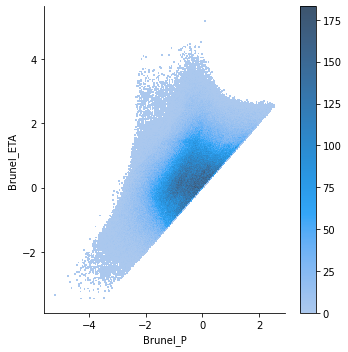

In [ ]:
sns.displot(data_train, x='Brunel_P', y='Brunel_ETA', cbar=True)

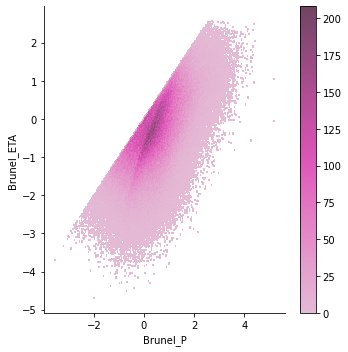

In [ ]:
sns.displot(data_val, x='Brunel_P', y='Brunel_ETA', cbar=True, color='tab:pink')

In [ ]:
data_train.head()

RichDLLe  RichDLLk  RichDLLmu  ...  Brunel_ETA  nTracks_Brunel  probe_sWeight
0 -0.724818  0.503850  -0.054387  ...    0.818981       -0.549087       0.965707
1 -0.855654  0.011117  -1.373068  ...    0.099490        1.174656       1.075660
2 -0.285117  0.399626  -0.794112  ...    0.891458       -0.130780       0.392297
3  1.096890  0.655933   0.758515  ...    2.232384       -0.504805       1.057160
4  1.953403  1.935392   2.209581  ...    1.520662       -1.035163       1.081870

[5 rows x 9 columns]

In [ ]:
data_val.head()

RichDLLe  RichDLLk  RichDLLmu  ...  Brunel_ETA  nTracks_Brunel  probe_sWeight
0  0.073264 -0.869542   2.596682  ...   -0.832458        0.530441       1.046920
1 -0.025900  0.208656  -0.014084  ...   -0.567182        0.484098       1.113120
2  2.264582 -0.321091   1.785567  ...   -0.440238        0.539581       0.360287
3  0.761812 -0.890729   0.935084  ...   -0.355777       -0.504805       0.789522
4 -0.801165  0.212812  -0.705148  ...   -0.930826        0.484098       1.151730

[5 rows x 9 columns]

In [10]:
feats_train, targets_train, _ = parse_dataset_np(data_train)
feats_val, targets_val, _ = parse_dataset_np(data_val)

feats_train.shape, targets_train.shape, feats_val.shape, targets_val.shape

((948452, 3), (948452, 5), (525855, 3), (525855, 5))

### Model definition, restoring from checkpoint

This chapter contains the only model definition and restores the model from the checkpoint. It does not contain training/evaluation routines since it was done in another notebook (look GAN training (line test).ipynb notebook).

In [11]:
def build_and_load_models(ckpt_dir):
    def build_model():
        model = RichMCDropV2Subcl(drop_rate=0.0)
        model.build((None, 3))

        return model

    ckpt_dirs = sorted(glob.glob(os.path.join(ckpt_dir, '*')))

    models = []
    for checkpoint in ckpt_dirs:
        model = build_model()
        ckpt = tf.train.Checkpoint(generator=model)
        ckpt.restore(tf.train.latest_checkpoint(checkpoint))

        print(tf.train.latest_checkpoint(checkpoint))

        models.append(model)

    return models

In [12]:
checkpoints_dir = 'btstrap_line_test_ckpts'
models = build_and_load_models(checkpoints_dir)

print(f"Number of models: {len(models)}")

btstrap_line_test_ckpts/btstrap_line_test_cramer_weighted_model_1/ckpt-21
btstrap_line_test_ckpts/btstrap_line_test_cramer_weighted_model_2/ckpt-21
btstrap_line_test_ckpts/btstrap_line_test_cramer_weighted_model_3/ckpt-21
btstrap_line_test_ckpts/btstrap_line_test_cramer_weighted_model_4/ckpt-21
btstrap_line_test_ckpts/btstrap_line_test_cramer_weighted_model_ref/ckpt-21
Number of models: 5


### Ensemble-based uncertainty

Since we are focused on assessing the systematic uncertainty and taking into account the fact that after standardization, the distribution of each $y_i$ is close to Gaussian, we may follow the approach from [here](https://colab.research.google.com/drive/1ypWf-J1buJ4svNvTKrvk4kQTYfjOnbrM?usp=sharing), i.e., the $\sigma_{systematic}$ could be approximated as 
$$\sigma^{systematic}_i = \sqrt{\frac{1}{2} (\mathbb{E}_{reference}[(y^{(1)}_i - y^{(2)}_i)^2] - \mathbb{E}_{ensemble}[(y^{(1)}_i - y^{(2)}_i)^2])},$$ where $y^{(1)}_i$ and $y^{(2)}_i$ are two randomly picked examples of target feature $y_i$, and $\mathbb{E}_{reference}$ and $\mathbb{E}_{ensemble}$ are the average operators computed across data produced by reference model and ensemble model respectively. The lightweight solution (without additional reference and ensemble models inference each time) is to learn models to approximate the residuals well. Since train and test splits are disjoint, fitting residuals on train data may lead to underestimated uncertainty. Thus, we use predictions from randomly generated data points to train residuals.  

In [ ]:
# ensemble_preds = [model(feats_train) for model in models[:-1]]
# # ensemble_preds_val = [model(feats_val) for model in models[:-1]]

# ref_model_preds = [models[-1](feats_train) for i in range(4)]
# # model_ref_preds_val = [model(feats_val) for model in models[:-1]]

In [13]:
size = int(1.5e6)

features = []
for idx in range(feats_train.shape[1]):
    min_ = min(feats_train[:, idx].min(), feats_val[:, idx].min())
    max_ = max(feats_train[:, idx].max(), feats_val[:, idx].max())

    features.append(tf.random.uniform([size, 1], min_, max_))

feats_gen = tf.concat(features, axis=1)
feats_gen.shape

TensorShape([1500000, 3])

In [14]:
# ensemble_size = 30
# ensemble_preds, ref_model_preds = ensemble_and_ref_model_inference(generator, 
#                                                                    feats_gen, 
#                                                                    ensemble_size)

ensemble_size = 2

ensemble_preds = [model(feats_gen) for model in models[:-1]]
ref_model_preds = [models[-1](feats_gen) for i in range(4)]

In [ ]:
ensemble_size = 1

input_data = np.repeat(feats_gen, ensemble_size, axis=0)

y_ref = np.concatenate([np.abs(p1 - p2) 
                        for p1, p2 in zip(ref_model_preds[:ensemble_size], 
                                          ref_model_preds[ensemble_size:])])

y_ens = np.concatenate([np.abs(p1 - p2) 
                        for p1, p2 in zip(ensemble_preds[0:1], 
                                          ensemble_preds[3:])])

input_data.shape, y_ref.shape, y_ens.shape

((1500000, 3), (1500000, 5), (1500000, 5))

In [ ]:
# Uncomment and run cell to remove checkpoints
# !rm -rf uncertainty_weights/line_split_ref

As discussed above, uncertainty computation requires training models which capture residuals. Below is shown training of these models. In our case, both models are simple 4-layer mlp with three hidden layers of 128 units. The loss function is MSE, Adam optimizer; Reduce on plateau approach is used for more efficient learning rate scheduling. Other parameters: initial learning rate is 1e-3, the batch size is 1e5. Models are trained for 100 epochs.

In [ ]:
base_path = 'uncertainty_weights/'
save_path_ref_model = os.path.join(base_path, 'line_split_ref', 'model_{epoch}')

ref_unc_model = uncertainty_mlp()

ref_unc_train_history = train_model(ref_unc_model, input_data, y_ref, 
                                    save_path_ref_model, lr=1e-3, batch_size=int(1e5), epochs=40)

Training:   0%|           0/40 ETA: ?s,  ?epochs/s

In [ ]:
# Uncomment and run cell to remove checkpoints
# !rm -rf uncertainty_weights/line_split_ens

In [ ]:
save_path_ens_model = os.path.join(base_path, 'line_split_ens', 'model_{epoch}')

ens_unc_model = uncertainty_mlp()
ens_unc_train_history = train_model(ens_unc_model, input_data, y_ens, 
                                    save_path_ens_model, lr=1e-3, batch_size=int(1e5), epochs=40)

Training:   0%|           0/40 ETA: ?s,  ?epochs/s

### Efficiency on bands

Unlike the iid train/test sampling experiment, the efficiencies are computed not for different ranges of momentum but for different "bands". Bands' widths are chosen so that each band contains the same number of examples (except last, which could contain less amount of data points), points from band 1 are closer to train/test line than points from band 2 (in terms of pseudorapidity (ETA) - momentum (P) plane), etc. The bands for the test set are illustrated below. 

In [15]:
def split_by_bands(feats, targets, band_size=106000):
    distances = np.abs(feats[:, 0] - feats[:, 1])
    sort_indices = np.argsort(distances)

    feats_sorted = feats[sort_indices]
    targets_sorted = targets[sort_indices]

    num_bands = (feats.shape[0] - 1) // band_size + 1

    bands = []
    for i in range(num_bands):
        start = i * band_size
        end = start + band_size

        band = (feats_sorted[start:end], targets_sorted[start:end])
        bands.append(band)

    return bands


def sample_bands(bands, length):
    bands_sampled = []

    for (x, y) in bands:
        indices = np.arange(x.shape[0])
        np.random.shuffle(indices)
        indices = indices[:length]
        bands_sampled.append((x[indices], y[indices]))

    return bands_sampled

In [16]:
bands_val = split_by_bands(feats_val, targets_val, band_size=105500)
bands_train = split_by_bands(feats_train, targets_train, band_size=105500)
bands_train = list(reversed(bands_train))

bands = bands_train + bands_val
min_length = min(list(map(lambda x: x[0].shape[0], bands)))

bands = sample_bands(bands, min_length)

num_train_bands = len(bands_train)
num_val_bands = len(bands_val)

num_train_bands, num_val_bands

(9, 5)

In [17]:
# bands = split_by_bands(feats_val, targets_val, band_size=52546) #105150)
# bands[-1][0].shape, len(bands)

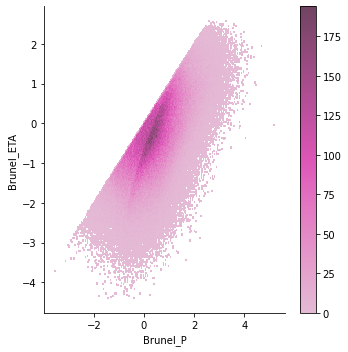

In [18]:
sns.displot(data_val, x='Brunel_P', y='Brunel_ETA', cbar=True, color='tab:pink')

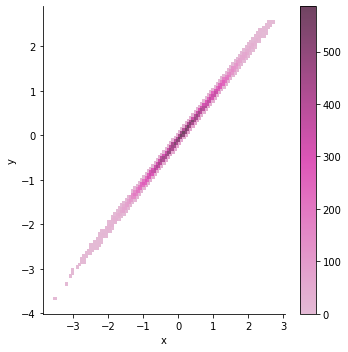

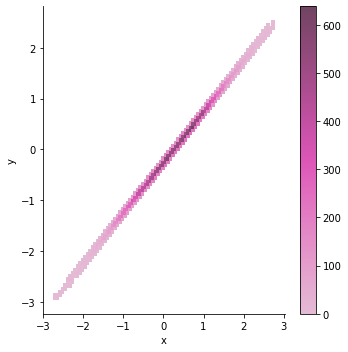

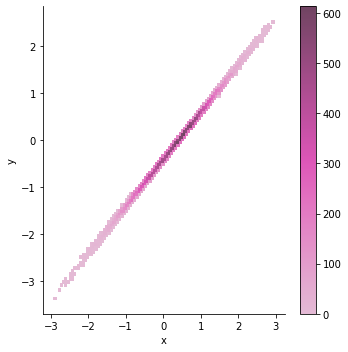

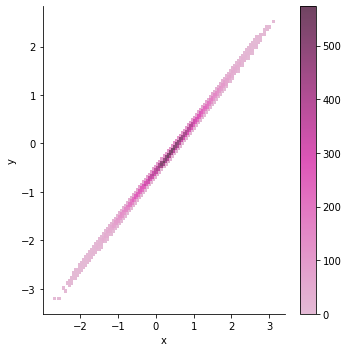

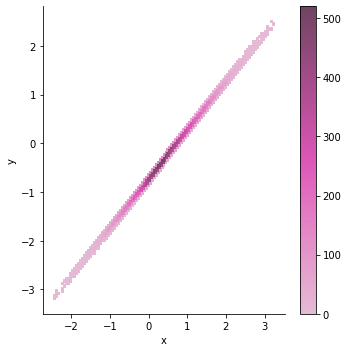

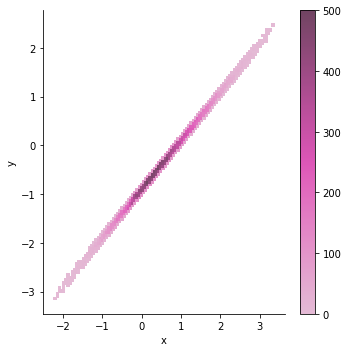

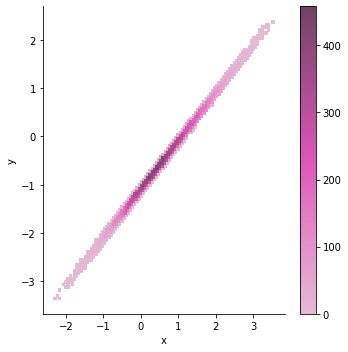

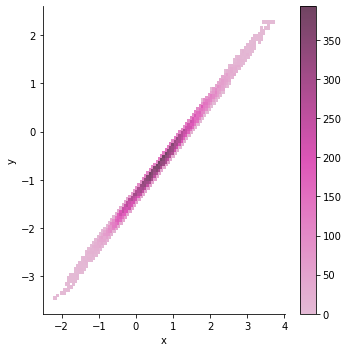

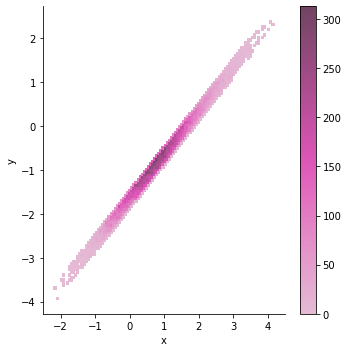

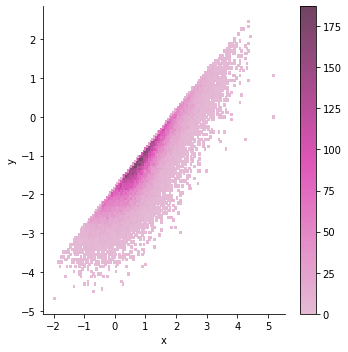

In [ ]:
for band in bands:
    feats, _ = band
    hist_df = pd.DataFrame(feats[:,:2], columns=['x', 'y'])
    sns.displot(hist_df, x='x', y='y', cbar=True, color='tab:pink')
    plt.show()

#### Results

Finally, we compute efficiency for each RichDLL and compute uncertainty bounds for each band. For prediction, we use a reference model, which is not a part of the ensemble. As it could be seen, the proposed ensemble-based uncertainty computation works well even on a completely unseen data region. Unlike the experiment with iid data, split models in ensemble produce diverse results, which leads to expectedly high uncertainty since train and test data have different distributions.

In [19]:
def ensemble_and_inference_on_bands(models, bands):
    ensemble_preds = []

    for model in models:

        bands_preds = []
        for band in bands:
            feats, _ = band

            target_gen = model(feats)
            bands_preds.append(target_gen.numpy())
        
        ensemble_preds.append(bands_preds)

    return ensemble_preds

In [23]:
band_ens_preds = ensemble_and_inference_on_bands(models, bands)
# band_single_preds = [models[-1](band[0]).numpy() for band in bands]

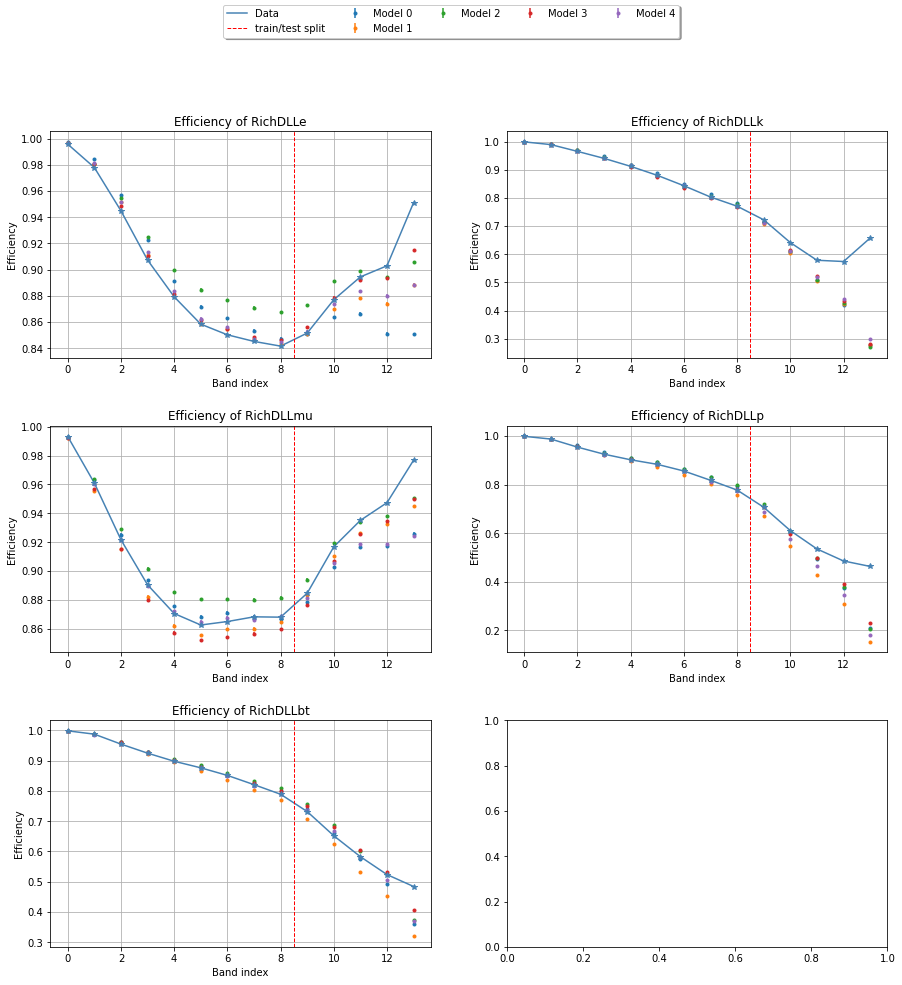

In [25]:
dll_columns = ['RichDLLe', 'RichDLLk', 'RichDLLmu', 'RichDLLp', 'RichDLLbt']

fig, axes = plt.subplots(3, 2, figsize=(15, 15))
plt.subplots_adjust(hspace = .3)

band_feats = list(map(lambda x: x[0], bands))
band_targets = list(map(lambda x: x[1], bands))

for idx, ax in zip((0, 1, 2, 3, 4), axes.flatten()):
    threshold = threshold_selection(targets_train[:, idx])

    model_plot_handlers = []
    for i, pred in enumerate(band_ens_preds):
        x, eff, err = efficiency_bands(pred, threshold, idx)
        handler = ax.errorbar(x, eff, err, fmt='.', label=f'Model {i}')
        model_plot_handlers.append(handler)

    # x, efficiency, eff_low, eff_high, errors = efficiency_bands_with_uncertainty(band_single_preds, 
    #                                                                              band_feats, 
    #                                                                              ens_unc_model,
    #                                                                              ref_unc_model,
    #                                                                              threshold, 
    #                                                                              idx)

    # x, eff, err = efficiency_bands(pred, threshold, idx)
    # ax.plot (x, eff, '-', color='tab:gray', label='Prediction')
    # handler = ax.errorbar(x, eff, err, fmt='.', label=f'Model {i}')

    x, eff, err = efficiency_bands(band_targets, threshold, idx)
    ax.errorbar(x, eff, err, fmt='*', color='steelblue')
    ax.plot(x, eff, label='Data', color='steelblue')

    # ax.plot (x, efficiency, '-', color='tab:gray', label='Prediction')
    # ax.plot (x, eff_high, '-.', color='tab:pink')
    # ax.plot (x, eff_low, '-.', label='Uncertainty bound', color='tab:pink')

    # y_low = min(eff_high) - 0.05

    ax.axvline(num_train_bands - 0.5, color='red', linestyle='--', linewidth=1, 
               label='train/test split')

    ax.set_title (f"Efficiency of {dll_columns[idx]}")
    ax.set_xlabel("Band index")
    ax.set_ylabel("Efficiency")
    # ax.set_ylim(y_low, 1.0)
    ax.grid()

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', fancybox=True, shadow=True, ncol=5)

plt.show()
fig.savefig('efficinecy_plots_line_test_train_val_data_btstrap.jpg')